## Cooking with ClarityNLP - Session #4

In this session of Cooking with ClarityNLP, we'll introduce integrations with OMOP and OHDSI. The main purpose is to introduce working with structed and unstructured data in one. We'll show how you can enhance vocabulary in ClarityNLP by using the OMOP vocabulary, how you can build more complete phenotypes using both structured and unstructured data, and how to export ClarityNLP results back to your OMOP database.

In [1]:
# Import dependencies
%matplotlib inline
import pandas as pd
pd.set_option('display.width',100000)
pd.set_option('max_colwidth',4000)
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

import claritynlp_notebook_helpers as claritynlp

ClarityNLP notebook helpers loaded successfully!


### MIMIC
In most of our Cooking sessions, we will use the MIMIC data. The MIMIC-III Critical Care Database is data set containing information about ICU patients who stayed at the Beth Israel Deaconess Hospital between 2001 and 2012. MIMIC-III has multiple types of clinical observational data, including text. It has been de-identified for research use. Unlike most public clinical data sets, unstructured text is available in the MIMIC-III database, making it suitable for our research

## Introduction to OHDSI / OMOP

#### Quick note on Setup

This tutorial assumes you have an [OHDSI WebAPI](https://github.com/OHDSI/WebAPI) up and running. We also use the [OHDSI Atlas](https://github.com/OHDSI/Atlas) tool for exploration. Visit [OHDSI.org](https://www.ohdsi.org/) to get up and going with OHDSI.

To setup OHDSI in ClarityNLP, your ClarityNLP instance needs access to your OHDSI WebAPI, set the `OHDSI_WEBAPI_URL` in your `.env` file. For example:                                                                                    

```
OHDSI_WEBAPI_URL=https://gt-apps.hdap.gatech.edu/ohdsi/WebAPI
```


### Use Case 1: Introduction to Synonyms in OHDSI

In this section, we'll explore term expansion in ClarityNLP. There are a variety of ways to expand terms in ClarityNLP, which we have introduced in previous sessions, and is documented [here](https://claritynlp.readthedocs.io/en/latest/user_guide/nlpql/macros.html). In the following example, we look at conditions related to having a low platelet count.

In [2]:
nlpql = '''

phenotype "LowPlateletTerms";

termset BruiseTerms:[
VerbInflections("bruise"),
OHDSI.Synonyms("purpura"),
OHDSI.Synonyms("contusion")
];

termset NoseBleedingTerms:[
OHDSI.Synonyms("epistaxis"),
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
OHDSI.Synonyms("petechia")
];


'''

expanded_nlpql = claritynlp.run_term_expansion(nlpql)
print(expanded_nlpql)



phenotype "LowPlateletTerms";

termset BruiseTerms:[
"bruise","bruised","bruises","bruising",
"peliosis","purpura","purpura (finding)","purpura (morphologic abnormality)",
"bruise","bruising","contusion","contusion (disorder)"
];

termset NoseBleedingTerms:[
"epistaxis",
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
"petechia","petechia (morphologic abnormality)","petechiae","petechial haemorrhage","petechial hemorrhage"
];





Since we're using SNOMED as the vocabulary, we get some extra terms that aren't as useful, but we can filter those out. If you have access to OHDSI Atlas, you can explore the OMOP vocabulary in finer detail, and can provide different terms that might not be found using `Synonyms`, `Ancestors` or `Descendants`.  

* [Georgia Tech Atlas](https://gt-apps.hdap.gatech.edu/ohdsi/atlas/#/concept/37220014)
* [Public Atlas](http://www.ohdsi.org/web/atlas/)

![atlas_vocab.png](assets/atlas_vocab.png)

### Use case 2: Comparing Structured Data with Symptoms found in ClarityNLP

In this next example, we'll look at symptoms found in ClarityNLP compared to structured data. In this case, we're looking at low platelet count. We define that in OHDSI simply by the following:

* A blood platelet count < 100

In ClarityNLP, we'll look for mentions of some of the [related conditions](https://www.healthline.com/health/thrombocytopenia#symptoms) to having a low platelet count:
* **red, purple, or brown bruises, which are called purpura**
* **a rash with small red or purple dots called petechiae**
* **nosebleeds**
* bleeding gums
* bleeding from wounds that lasts for a prolonged period or doesn’t stop on its own
* heavy menstrual bleeding
* bleeding from the rectum
* blood in your stool
* blood in your urine

For this demo, we'll just pick a few to test ClarityNLP.

In [14]:
nlpql = '''

phenotype "LowPlateletConditions";

documentset DocNotes:
    Clarity.createReportTypeList(["Physician "]);
    
termset BruiseTerms:[
"bruise","bruised","bruises","bruising",
"peliosis","purpura",
"bruise","bruising","contusion"
];

termset NoseBleedingTerms:[
"epistaxis",
"nosebleed", "nosebleeds", "nosebleeding",
"nose bleed", "nose bleeds", "nose bleeding",
"petechia","petechiae","petechial haemorrhage","petechial hemorrhage",
"nasal haemorrhage","nasal hemorrhage"
];

define hasBruising:
Clarity.ProviderAssertion({
  termset: [BruiseTerms],
  documentset: [DocNotes]
});

define hasBleeding:
Clarity.ProviderAssertion({
  termset: [NoseBleedingTerms],
  documentset: [DocNotes]
});

context Patient;

define final hasLowPlateletConditions:
    where hasBruising AND hasBleeding;
'''
run_result, main_csv, intermediate_csv, luigi = claritynlp.run_nlpql(nlpql)

Job Successfully Submitted
{
    "intermediate_results_csv": "http://18.220.133.76:5000/job_results/539/phenotype_intermediate",
    "job_id": "539",
    "luigi_task_monitoring": "http://18.220.133.76:8082/static/visualiser/index.html#search__search=job=539",
    "main_results_csv": "http://18.220.133.76:5000/job_results/539/phenotype",
    "phenotype_config": "http://18.220.133.76:5000/phenotype_id/539",
    "phenotype_id": "539",
    "pipeline_configs": [
        "http://18.220.133.76:5000/pipeline_id/740",
        "http://18.220.133.76:5000/pipeline_id/741"
    ],
    "pipeline_ids": [
        740,
        741
    ],
    "results_viewer": "?job=539",
    "status_endpoint": "http://18.220.133.76:5000/status/539"
}


In [32]:
inter_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/539/phenotype_intermediate')
inter_csv_df.head()

,_id,batch,concept_code,end,experiencer,inserted_date,job_id,negation,nlpql_feature,owner,...,report_id,report_type,section,sentence,solr_id,source,start,subject,temporality,term
0,5bbce10e142135056b0876e3,1025,-1,73,Patient,2018-10-09 17:10:38.002000,539,Affirmed,hasBruising,claritynlp,...,507228,Physician,ASSESSMENT_AND_PLAN,"24 y/o female s/p blunt head injury, negative head CT, possible contusion vs. developing SDH",507228,MIMIC,64,31628,Historical,contusion
1,5bbce10e14213505650876e3,1475,-1,83,Patient,2018-10-09 17:10:38.502000,539,Affirmed,hasBruising,claritynlp,...,533632,Physician,RADIOGRAPHIC_STUDIES,CXR Residual consolidation in the left lower lung could be atelectasis or contusion or aspiration.,533632,MIMIC,74,42067,Recent,contusion
2,5bbce10f142135056e0876e3,525,-1,191,Patient,2018-10-09 17:10:39.177000,539,Affirmed,hasBruising,claritynlp,...,588420,Physician,CEREBRAL_ANGIOGRAPHY,There has been progression of intracranial hemorrhage since prior study of 4 hours earlier: new foci of parenchymal hemorrhage in the right frontal cortex inferiorly could be due to contusion.,588420,MIMIC,182,42052,Historical,contusion
3,5bbce10f142135056e0876e4,525,-1,61,Patient,2018-10-09 17:10:39.181000,539,Affirmed,hasBruising,claritynlp,...,588420,Physician,CEREBRAL_CT,"little interval change in right frontal hemorrhagic contusion with surrounding edema, subarachnoid blood also appears unchanged [**4-8**] CT angio",588420,MIMIC,52,42052,Recent,contusion
4,5bbce10f14213505650876e4,1475,-1,107,Patient,2018-10-09 17:10:39.290000,539,Affirmed,hasBruising,claritynlp,...,536242,Physician,HISTORY_PRESENT_ILLNESS,"Head CT shows an old posterior right temporal hypodensity, likely encephalomalacia from her prior contusion.",536242,MIMIC,98,12925,Historical,contusion


In [37]:
main_csv_df = pd.read_csv('http://18.220.133.76:5000/job_results/539/phenotype')
main_csv_df.head()

,_id,_id_x,_id_y,context_type,job_date,job_id,nlpql_feature,nlpql_feature_x,nlpql_feature_y,owner,phenotype_final,phenotype_id,raw_definition_text,report_date_x,report_date_y,report_id_x,report_id_y,sentence_x,sentence_y,subject
0,5bbcebe11421350f220876e3,5bbce13c142135056b0876f6,5bbce4ef14213508f10876ea,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628692,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
1,5bbcebe11421350f220876e4,5bbce13c142135056b0876f6,5bbce4f514213508f10876ef,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628688,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
2,5bbcebe11421350f220876e5,5bbce13c142135056b0876f6,5bbce4fb14213508fc0876e4,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,628507,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.",Given dark NG lavage and small amount suctioned (20cc).This GI collected blood may be secondary to ingested hempotysis source or from a nasopharyngeal /nosebleed in the setting of an elevated INR vs. true pulmonary source and overt hemoptysis.,39166
3,5bbcebe11421350f220876e6,5bbce13c142135056b0876f6,5bbce8b41421350c4f087713,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,627661,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166
4,5bbcebe11421350f220876e7,5bbce13c142135056b0876f6,5bbce8b61421350c4f087714,subject,2018-10-09 17:56:49.197000,539,hasLowPlateletConditions,hasBruising,hasBleeding,539,True,539,hasBruising AND hasBleeding,2199-08-05T00:00:00Z,2199-08-05T00:00:00Z,627661,627663,"Per OSH notes, the patient initially presented yesturday afternoon to OSH ED complaining of left ankle and tibial pain and bruising after hitting his leg on the car door.","COUGHING BLOOD -- unclear whether blood represents hemoptysis, GI bleeding/hematemesis, or epistaxis.",39166


We can see that from the ClarityNLP [result viewer](http://18.220.133.76:8200/?job=538), we have some patients who have potential for having low platelet count. Now, let's integrate an OHDSI cohort to see how the data sets compare.

![results_viewer.png](assets/results_viewer.png)

### Creating Cohorts from Structured Data

OHDSI Atlas has an extensive builder for building out cohorts on structured data. In this case, we'll look at patients who've had a platelet count using a platelet measure less than 100.
![low_platelet_cohort.png](assets/low_platelet_cohort.png)

In [17]:
# Low Platelet Cohort JSON
# OHDSI Cohorts can be shared via JSON, an example is shown here.
json = '''
{
  "ConceptSets": [
    {
      "id": 0,
      "name": "Platelets",
      "expression": {
        "items": [
          {
            "concept": {
              "CONCEPT_ID": 3024929,
              "CONCEPT_NAME": "Platelets [#/volume] in Blood by Automated count",
              "STANDARD_CONCEPT": "S",
              "INVALID_REASON": "V",
              "CONCEPT_CODE": "777-3",
              "DOMAIN_ID": "Measurement",
              "VOCABULARY_ID": "LOINC",
              "CONCEPT_CLASS_ID": "Lab Test",
              "STANDARD_CONCEPT_CAPTION": "Standard",
              "INVALID_REASON_CAPTION": "Valid"
            }
          }
        ]
      }
    }
  ],
  "PrimaryCriteria": {
    "CriteriaList": [
      {
        "Measurement": {
          "CodesetId": 0,
          "ValueAsNumber": {
            "Value": 100,
            "Op": "lte"
          }
        }
      }
    ],
    "ObservationWindow": {
      "PriorDays": 0,
      "PostDays": 0
    },
    "PrimaryCriteriaLimit": {
      "Type": "First"
    }
  },
  "QualifiedLimit": {
    "Type": "First"
  },
  "ExpressionLimit": {
    "Type": "First"
  },
  "InclusionRules": [],
  "CensoringCriteria": [],
  "CollapseSettings": {
    "CollapseType": "ERA",
    "EraPad": 0
  },
  "CensorWindow": {}
}
'''

### Comparing OHDSI and ClarityNLP data sets

Now let's explore OHDSI and ClarityNLP data sets. Note that we might not find much in common in here, because in ClarityNLP, we're looking at patients with a couple low platelet symptoms. While in OHDSI, we're looking at people who've been found to have a low platelet count.


We'll begin by loading up the OHDSI cohort into a data frame.

In [6]:
low_platelet_patients = pd.DataFrame(claritynlp.get_cohort_patients(356)['Patients'])
low_platelet_patients.head()

,cohortDefinitionId,cohortEndDate,cohortStartDate,subjectId
0,356,4515264000000,4512585600000,29821
1,356,4537900800000,4535222400000,38681
2,356,5180112000000,5173027200000,44187
3,356,4626633600000,4626201600000,10243
4,356,7280323200000,7276521600000,15859


In [39]:
low_platelet_patients.shape

(8031, 4)

In [40]:
inter_csv_df.shape

(4684, 24)

Note that the ClarityNLP data set has multiple patients because we're looking at each instance of bleeding or bruising (we'll fix that in a second). What else can we learn by comparing these 2 data sets?

In [41]:
def get_patient_sets(clarity_df, ohdsi_df):
    unique_clarity_patients = set(clarity_df['subject'])
    unique_ohdsi_patients = set(ohdsi_df['subjectId'])
    print("Union :", len(unique_clarity_patients | unique_ohdsi_patients))
    print("Intersection :", len(unique_clarity_patients & unique_ohdsi_patients))
    print("Difference (OHDSI - ClarityNLP):", len(unique_ohdsi_patients - unique_clarity_patients))
    print("Difference (ClarityNLP - OHDSI):", len(unique_clarity_patients - unique_ohdsi_patients))
    venn2([unique_clarity_patients, unique_ohdsi_patients], set_labels=('ClarityNLP', 'OHDSI'))
    
    return unique_clarity_patients, unique_ohdsi_patients


ClarityNLP Patients with Bleeding or Bruising.
OHDSI Patients with Low Platelets.

Union : 8450
Intersection : 184
Difference (OHDSI - ClarityNLP): 7847
Difference (ClarityNLP - OHDSI): 419


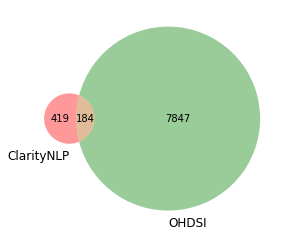

In [42]:
print('ClarityNLP Patients with Bleeding or Bruising.')
print('OHDSI Patients with Low Platelets.')
print()
unique_clarity_patients, unique_ohdsi_patients = get_patient_sets(inter_csv_df, low_platelet_patients)

So, we only found 184 patients with condistion in ClarityNLP related to a low platelet count. What might be a reason the numbers or so low?

* We don't have notes on all the patients in MIMIC.
* We only look at Physician notes, maybe in the future we should expand that.
* We didn't specifically look for "low platelet" or even all the symptoms related to having a low platelet count.

Let's look at patients who had bleed and bruising.

ClarityNLP Patients with Bleeding and Bruising.
OHDSI Patients with Low Platelets.

Union : 8053
Intersection : 22
Difference (OHDSI - ClarityNLP): 8009
Difference (ClarityNLP - OHDSI): 22


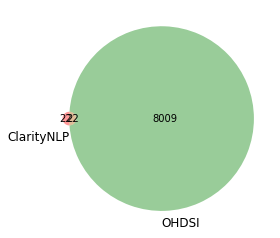

In [48]:
print('ClarityNLP Patients with Bleeding and Bruising.')
print('OHDSI Patients with Low Platelets.')
print()
unique_clarity_patients, unique_ohdsi_patients = get_patient_sets(main_csv_df, low_platelet_patients)

Note that the patients that were found to have 

This is an introductory example on how to compare OHDSI and ClarityNLP. We'll dig into further examples on this data and others on how ClarityNLP and OMOP integrate. 